In [39]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# Helper functions

In [2]:
def create_network(year, threshold = 0):
    # Function for creating a directed weighted network of migration flows across municipalities
    df = pd.read_csv(f'./datasets/domestic_migration_{year}.csv')
    df['arrival_code'] = df['Area of arrival'].apply(lambda z: z[10:13])
    df['arrival'] = df['Area of arrival'].apply(lambda z: z[14:])
    df['departure_code'] = df['Area of departure'].apply(lambda z: z[12:15])
    df['departure'] = df['Area of departure'].apply(lambda z: z[16:])
    df['value'] = df['value'].astype('int')
    
    select = df[df['value'] > threshold].sort_values('value', ascending=False)
    temp = select[['departure_code', 'arrival_code', 'value']].values.tolist()
    weighted_edges = [(x[0], x[1], x[2]) for x in temp]
    weights = [x[2] for x in temp]
    
    # create graph
    G = nx.DiGraph()
    G.add_weighted_edges_from(weighted_edges)
    
    return G, weights, df

In [3]:
# Create dictionaries mapping municipality codes to municipality names and vice versa
G, weights, df = create_network(2020)

municipalities = list(df['arrival'])
municipality_codes = list(df['arrival_code'])
municipality_dict = {}
municipality_name_dict = {}
for m, mc in zip(municipalities, municipality_codes):
    if mc not in municipality_dict:
        municipality_dict[mc] = m
    if m not in municipality_name_dict:
        municipality_name_dict[m] = mc

In [4]:
df_key = pd.read_csv(f'./datasets/municipal_key_figures_1990_2021.csv', encoding = 'latin-1')

def create_key_figure_dictionary(key_figure):
    # Create dictionary of given key figure information on all years
    # Key figure values can be accessed from the returned dictionary by indexing dict[municipality_name][year]
    years = range(1990, 2022)

    df_key_figure = df_key[(df_key['Information'] == key_figure)]
    key_figure_list = df_key_figure[['Region 2021'] + [str(year) for year in years]].values.tolist()

    key_figure_dict = {}
    for elem in key_figure_list:
        municipality = elem[0]
        key_figures = elem[1:]
        key_figure_dict[municipality] = {}
        for i in range(len(years)):
            key_figure_dict[municipality][years[i]] = key_figures[i]

    # For some reason Maalahti is in Finnish in the English data even when all other Swedish-speaking municipalities are in Swedish
    # To fix this, let's add Maalahti (Malax in Swedish) to the dictionary manually
    key_figure_dict['Maalahti'] = {}
    for i in range(len(years)):
        key_figure_dict['Maalahti'][years[i]] = key_figure_dict['Malax'][years[i]]
        
    return key_figure_dict


# Create dictionary of municipality populations on each year
population = create_key_figure_dictionary('Population')

In [5]:
def visualize_migration_network(df = None, graph = None, threshold = 100):
    # Function from the demo, modified to accept graph input and a custom threshold
    # If a directed graph is given, plots the edges as arrows!
    
    if df is None and graph is None:
        print("Provide either a dataframe or a graph!")
        return
    
    gdf_kunta = gpd.read_file('./datasets/kunta4500k_2022.geojson')
    dict_centroid = dict(zip(gdf_kunta['kunta'], gdf_kunta.geometry.centroid.apply(lambda z: z.coords[0])))
    
    if df is not None:
        select = df[df['value'] > threshold].sort_values('value', ascending=False)
        temp = select[['departure_code', 'arrival_code']].values.tolist()
        edges = [(x[0], x[1]) for x in temp]
        temp = select[['value']].values.tolist()
        edge_sizes = [x[0] for x in temp]
    
        graph_to_plot = nx.Graph()
        graph_to_plot.add_edges_from(edges)
        
    elif graph is not None:
        graph_to_plot = graph.copy()
        edge_sizes = []
        for u,v,data in graph.edges(data=True):
            w = data['weight']
            if w > threshold:
                edge_sizes.append(w)
            else:
                graph_to_plot.remove_edge(u,v)

    edge_sizes = [x / 1000 + 1 for x in edge_sizes]
    
    ax = gdf_kunta.plot(ec='black', fc='white', linewidth=0.5, figsize=(5, 10))

    nx.draw_networkx_edges(ax=ax,
                           G=graph_to_plot,
                           pos=dict_centroid,
                           width=edge_sizes,
                           edge_color ='C1',
                           alpha=0.7)
    ax.set_axis_off()

In [227]:
gdf_kunta = gpd.read_file('./datasets/kunta4500k_2022.geojson')
dict_centroid = dict(zip(gdf_kunta['kunta'], gdf_kunta.geometry.centroid.apply(lambda z: z.coords[0])))

def get_distance(coords1, coords2):
    return np.sqrt((coords1[0] - coords2[0])**2 + (coords1[1] - coords2[1])**2) / 1000

# Gravity model

## Basic model

The basic gravity model states that movement from place 1 with population $P_1$ to place 2 with population $P_2$, when the places have a distance $D_{12}$ between them, is proportional to $\frac{P_1 \cdot P_2}{D_{12}}$. This basic model emphasises Helsinki quite a lot, though, so an exponent to the distance term was introduced. Below, the original gravity model and two alternative with exponents $1.5$ and $2$ are examined and compared.

In order to examine the differences between the original and expected network, the weights of both are normalised to sum up to 1. Therefore individual weights $w_{ij}$ of the network edges $e_{ij}$ now represent the probabilities that if a single person migrates in the network, they migrate from municipality $i$ to $j$. Note that the original network does not include all possible edges, as there was no migration from every municipality to every other municipality. The expected networks constructed with the gravity model do include all possible edges, though.

In [24]:
def create_original_and_expected_network(year, exponent):
    # Actual migration in the given year
    G_orig, weights, _ = create_network(year)

    # Normalise edge weights so they add up to 1
    for u,v,data in G_orig.edges(data=True):
        w = data['weight']
        G_orig[u][v]['weight'] = w / sum(weights)


    # Calculate expected migration network based on the gravity model
    G_grav = nx.DiGraph()

    total = 0
    for u in G_orig.nodes():
        for v in G_orig.nodes():
            if u != v:
                expected_migration = population[municipality_dict[u]][year] * population[municipality_dict[v]][year]
                expected_migration /= (get_distance(dict_centroid[u], dict_centroid[v]))**exponent
                G_grav.add_edge(u,v,weight=expected_migration)
                total += expected_migration

    # Normalise edge weights so they add up to 1
    for u,v,data in G_grav.edges(data=True):
        w = data['weight']
        G_grav[u][v]['weight'] = w / total
        
    return G_orig, G_grav

G_orig, G_grav1 = create_original_and_expected_network(2021, 1)
_, G_grav15 = create_original_and_expected_network(2021, 1.5)
_, G_grav2 = create_original_and_expected_network(2021, 2)

## Alternative model

In the alternative gravity model, the migration flows are proportional to the municipality inflows and outflows instead of populations. The weights are proportional to $O_1 \frac{I_2 D_{12}}{\sum_{k=1}^n I_k D_{1k}}$, where $O_1$ and $I_2$ are the outflow of the depature and inflow of the arrival municipality, respectively. $D_{12}$ is once again the distance between them, and can be raised to a power if wanted to.

In [7]:
def create_original_and_expected_network_alternative(year, exponent):
    # Actual migration in the given year
    G_orig, weights, _ = create_network(year)

    # Normalise edge weights so they add up to 1
    for u,v,data in G_orig.edges(data=True):
        w = data['weight']
        G_orig[u][v]['weight'] = w / sum(weights)


    # Calculate expected migration network based on the alternative gravity model,
    # which utilises inflows and outflows instead of populations
    G_grav = nx.DiGraph()
    
    in_degrees = {node:in_degree for (node, in_degree) in G_orig.in_degree(weight='weight')}
    out_degrees = {node:out_degree for (node, out_degree) in G_orig.out_degree(weight='weight')}

    total = 0
    for i in G_orig.nodes():
        sum_denominator_i = 0.0
        for k in G_orig.nodes():
            if i != k:
                sum_denominator_i += in_degrees[k] / (get_distance(dict_centroid[i], dict_centroid[k]))**exponent
        for j in G_orig.nodes():
            if i != j:
                expected_migration = out_degrees[i] * in_degrees[j] / (get_distance(dict_centroid[i], dict_centroid[j]))**exponent
                expected_migration /= sum_denominator_i
                G_grav.add_edge(i,j,weight=expected_migration)
                total += expected_migration

    # Normalise edge weights so they add up to 1
    for u,v,data in G_grav.edges(data=True):
        w = data['weight']
        G_grav[u][v]['weight'] = w / total
        
    return G_orig, G_grav

G_orig, G_grav1 = create_original_and_expected_network_alternative(2021, 1)
_, G_grav15 = create_original_and_expected_network_alternative(2021, 1.5)
_, G_grav2 = create_original_and_expected_network_alternative(2021, 2)

## Migration flows

/opt/software/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/software/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/software/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/software/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecat

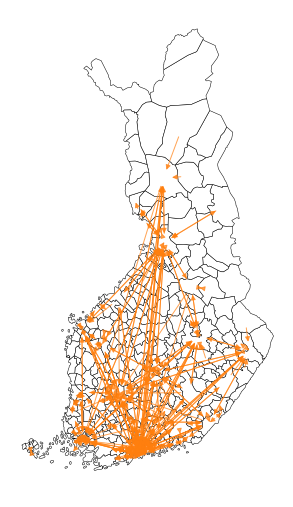

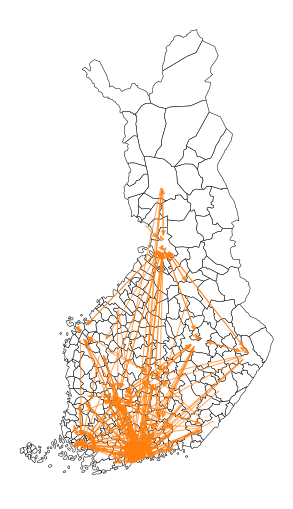

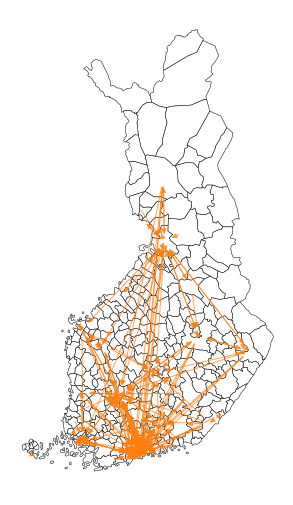

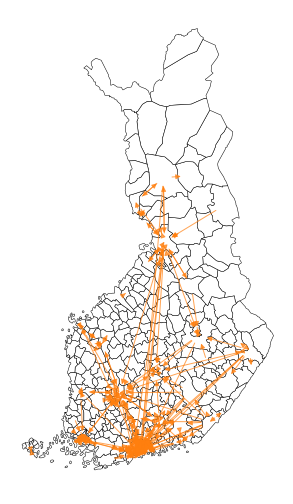

In [18]:
# Visualise largest migration flows
# Normalise threshold because weights have been normalised, too
threshold = 100
threshold_normalised = threshold/sum(weights)

visualize_migration_network(graph=G_orig, threshold=threshold_normalised)
visualize_migration_network(graph=G_grav1, threshold=threshold_normalised)
visualize_migration_network(graph=G_grav15, threshold=threshold_normalised)
visualize_migration_network(graph=G_grav2, threshold=threshold_normalised)

## Maximum spanning trees

/opt/software/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/software/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/software/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/software/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecat

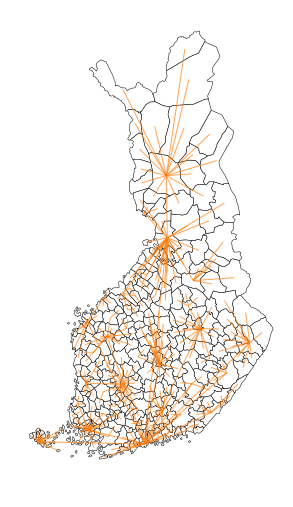

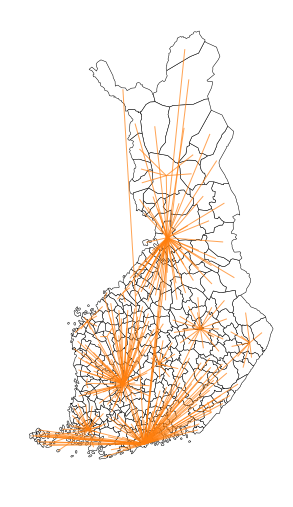

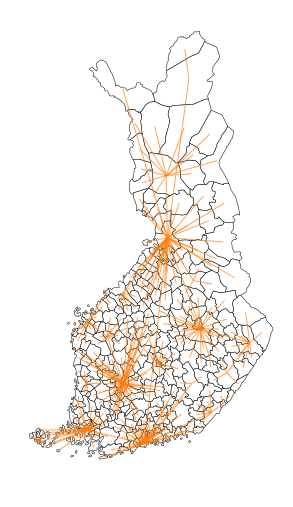

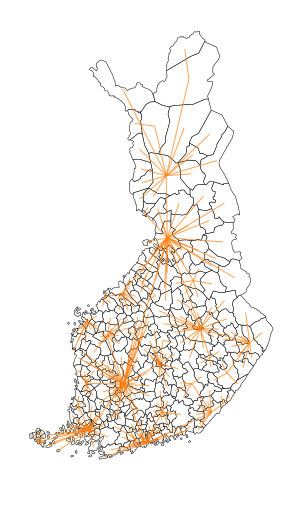

In [21]:
# First, create an undirected network where the edge weights are the sums of migrants in both directions (for now)
def create_undirected_network(G):
    G_undir = nx.Graph()
    for u,v,data in G.edges(data=True):
        w = data['weight']
        if G_undir.has_edge(u,v):
            G_undir[u][v]['weight'] += w
        else:
            G_undir.add_edge(u, v, weight=w)
    return G_undir

G_orig_undir = create_undirected_network(G_orig)
G_grav1_undir = create_undirected_network(G_grav1)
G_grav15_undir = create_undirected_network(G_grav15)
G_grav2_undir = create_undirected_network(G_grav2)


# The MSTs
mst = nx.maximum_spanning_tree(G_orig_undir)
visualize_migration_network(graph=mst, threshold=0)
mst_grav1 = nx.maximum_spanning_tree(G_grav1_undir)
visualize_migration_network(graph=mst_grav1, threshold=0)
mst_grav15 = nx.maximum_spanning_tree(G_grav15_undir)
visualize_migration_network(graph=mst_grav15, threshold=0)
mst_grav2 = nx.maximum_spanning_tree(G_grav2_undir)
visualize_migration_network(graph=mst_grav2, threshold=0)

The first visualisations show that as the exponent increases, the gravity model does predicts less and less migration flow between the large cities of Finland, and predicts that the largest flows are from and to Helsinki by far. This is likely due to the much higher population of Helsinki compared to other municipalities. However, the second visualisations of the MSTs show that increasing the exponent has an upside: the gravity models with the higher exponents capture an important phenomenon present in the original network - large cities attract people from nearby, smaller municipalities. The first gravity model fails to capture this and emphasises Helsinki instead.

## Accuracy of the models

### Normalized root mean square error

In [30]:
def normalise_to_integers(original_network, expected_network, year, verbose):
    _, weights, _ = create_network(year)
    total = sum(weights)
    
    # Edge weights should be transformed back to integers representing the number of migrants
    # Also remove edges with weight 0 here
    G_original = original_network.copy()
    for u,v,data in original_network.edges(data=True):
        w = data['weight']
        G_original[u][v]['weight'] = round(w * total, 0)
        if G_original[u][v]['weight'] == 0:
            G_original.remove_edge(u,v)
    G_expected = expected_network.copy()
    for u,v,data in expected_network.edges(data=True):
        w = data['weight']
        G_expected[u][v]['weight'] = round(w * total, 0)
        if G_expected[u][v]['weight'] == 0:
            G_expected.remove_edge(u,v)
    
    if verbose:
        print(f"Original number of links: {len(G_original.edges(data=True))}, " \
              f"expected number of links: {len(G_expected.edges(data=True))}")
    
    return G_original, G_expected

In [32]:
# Calculate NRMSE between networks by comparing their weights

def calculate_nrmse(original_network, expected_network, year, verbose=False):
    _, weights, _ = create_network(year)
    total = sum(weights)
    
    G_original, G_expected = normalise_to_integers(original_network, expected_network, year, verbose)
    
    error = 0
    for u in original_network.nodes():
        for v in original_network.nodes():
            if u != v:
                if G_original.has_edge(u,v):
                    w1 = G_original[u][v]['weight']
                else:
                    w1 = 0
                if G_expected.has_edge(u,v):
                    w2 = G_expected[u][v]['weight']
                else:
                    w2 = 0
                error += (w1 - w2)**2
    
    mean_error = error / total
    return mean_error


for model in [G_grav1, G_grav15, G_grav2]:
    mean_error = calculate_nrmse(G_orig, model, 2021, True)
    print(f"{mean_error:.3f}")

Original number of links: 19768, expected number of links: 31081
172.731
Original number of links: 19768, expected number of links: 27161
639.335
Original number of links: 19768, expected number of links: 21961
1280.361


The model with the distance term by itself produced the lowest error of $\approx 639.6$, while the other two produced errors of $\approx 4376.0$ and $\approx 11178.9$. This is likely because the first model does not penalise migration flows between large cities far away from each other as much and is therefore more accurate for them. However, as mentioned above, the two other models seem to capture certain phenomena in the network that the first model doesn't, and are more accurate in that sense.

### Common part of commuters (migrants)

In [34]:
# How similar are the two networks? How well does the gravity model predict the migration flows?

def common_part_of_commuters(original_network, expected_network, year, verbose=False):
    _, weights, _ = create_network(year)
    total = sum(weights)
    
    G_original, G_expected = normalise_to_integers(original_network, expected_network, year, verbose)
                
    # Then, calculate common part of commuters (migrants)
    cpc_numerator = 0
    for u in original_network.nodes():
        for v in original_network.nodes():
            if u != v:
                if G_original.has_edge(u,v) and G_expected.has_edge(u,v):
                    cpc_numerator += min(G_original[u][v]['weight'], G_expected[u][v]['weight'])
    
    cpc = cpc_numerator / total
    return cpc
    
    
for model in [G_grav1, G_grav15, G_grav2]:
    cpc = common_part_of_commuters(G_orig, model, 2021, True)
    print(f"{cpc:.3f}")

Original number of links: 19768, expected number of links: 31081
0.660
Original number of links: 19768, expected number of links: 27161
0.670
Original number of links: 19768, expected number of links: 21961
0.643


As the model exponent increases, the model accuracy decreases.

### Common part of links

In [36]:
# How well does the gravity model preserve the topology of the network?

def common_part_of_links(original_network, expected_network, year, verbose=False):
    G_original, G_expected = normalise_to_integers(original_network, expected_network, year, verbose)
                
    # Calculate common part of links
    cpl_numerator = 0
    cpl_denominator = 0
    for u in original_network.nodes():
        for v in original_network.nodes():
            if u != v:
                if G_original.has_edge(u,v) and G_expected.has_edge(u,v):
                    cpl_numerator += 2
                if G_original.has_edge(u,v):
                    cpl_denominator += 1
                if G_expected.has_edge(u,v):
                    cpl_denominator += 1
    
    cpl = cpl_numerator / cpl_denominator
    return cpl
    
    
for model in [G_grav1, G_grav15, G_grav2]:
    cpl = common_part_of_links(G_orig, model, 2021, True)
    print(f"{cpl:.3f}")

Original number of links: 19768, expected number of links: 31081
0.620
Original number of links: 19768, expected number of links: 27161
0.638
Original number of links: 19768, expected number of links: 21961
0.642


Surprisingly, the model with the exponent $1.5$ produces the best score here. None of the CPL scores are especially high or good, though, especially taking into account that the first two models preserve more or a similar amount of links to the original network, but not the topology (i.e. a lot of new links appear).

### Model accuracy across years

In [67]:
# Let's calculate the NRMSE, CPC, and CPL for each year
nrmses = []
cpcs = []
cpls = []

years = range(1990, 2022)
for year in years:
    # Create original and expected network for the year
    G_original, G_expected = create_original_and_expected_network_alternative(year, 1.5)  # exponent 1.5 produced the best results, so let's use it
    
    # Calculate and save the metrics
    nrmse = calculate_nrmse(G_original, G_expected, year)
    cpc = common_part_of_commuters(G_original, G_expected, year)
    cpl = common_part_of_links(G_original, G_expected, year)
    
    nrmses.append(nrmse)
    cpcs.append(cpc)
    cpls.append(cpl)
    
print("Metrics calculated and saved!")

Metrics calculated and saved!


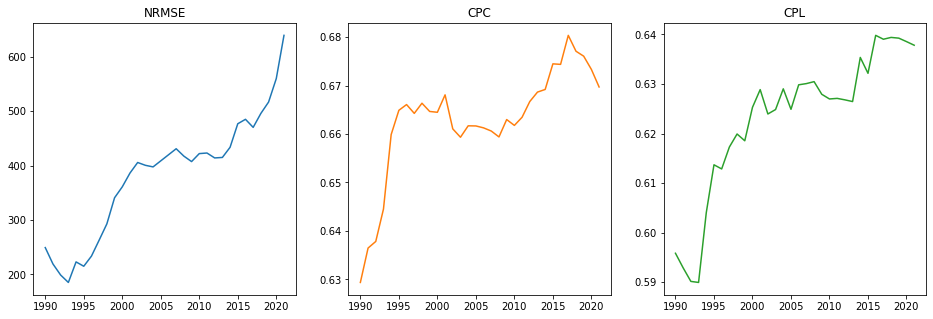

In [68]:
# Plot the calculated metrics
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(16, 5)

metrics = [nrmses, cpcs, cpls]
titles = ['NRMSE', 'CPC', 'CPL']
colours = ['tab:blue', 'tab:orange', 'tab:green']
for i in range(len(metrics)):
    axs[i].plot(years, metrics[i], colours[i])
    axs[i].title.set_text(titles[i])
plt.show()

### Accuracies of east-west vs. north-south migration

In [94]:
# Is North-South directional migration predicted better than East-West directional migration?
# Divide weights into two groups: North-South (NS) and East-West (EW), calculate average errors for both groups

def NS_or_EW(u, v):
    """
    Check if the weight between nodes u and v is north-south directional or east-west directional.
    Returns True for NS and False for EW.
    """
    x1, y1 = dict_centroid[u]
    x2, y2 = dict_centroid[v]
    # If |y2 - y1| is larger than |x2 - x1|, the weight is classified as NS, otherwise as EW
    if abs(y2 - y1) > abs(x2 - x1):
        return True
    return False


def NS_vs_EW_error(original_network, expected_network, year, verbose=False):
    G_original, G_expected = normalise_to_integers(original_network, expected_network, year, verbose)
    
    ns_error = 0
    ns_total = 0
    ew_error = 0
    ew_total = 0
    for u in original_network.nodes():
        for v in original_network.nodes():
            if u != v:
                if G_original.has_edge(u,v):
                    w1 = G_original[u][v]['weight']
                else:
                    w1 = 0
                if G_expected.has_edge(u,v):
                    w2 = G_expected[u][v]['weight']
                else:
                    w2 = 0
                    
                ns = NS_or_EW(u, v)
                if ns:
                    ns_error += (w1 - w2)**2
                    ns_total += w1
                else:
                    ew_error += (w1 - w2)**2
                    ew_total += w1
                    
    ns_mean_error = ns_error / ns_total
    ew_mean_error = ew_error / ew_total
    return ns_total, ew_total, ns_mean_error, ew_mean_error

In [99]:
# Calculate the total migrants and mean errors for each year and both directions (NS and EW)
ns_totals = []
ew_totals = []
ns_nrmses = []
ew_nrmses = []

for year in years:
    G_original, G_expected = create_original_and_expected_network_alternative(year, 1.5)
    ns_total, ew_total, ns_nrmse, ew_nrmse = NS_vs_EW_error(G_original, G_expected, year)
    
    ns_totals.append(ns_total)
    ew_totals.append(ew_total)
    ns_nrmses.append(ns_nrmse)
    ew_nrmses.append(ew_nrmse)
    
print("Metrics calculated and saved!")

Metrics calculated and saved!


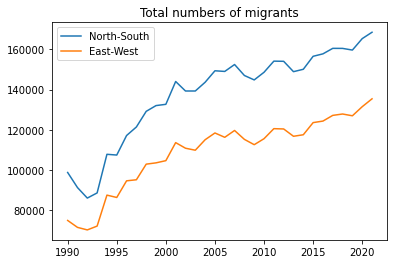

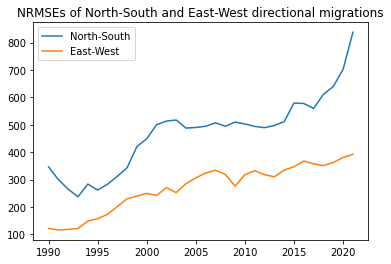

In [105]:
# Plot the total number of migrants in both directions
plt.plot(years, ns_totals, label="North-South")
plt.plot(years, ew_totals, label="East-West")
plt.legend()
plt.title("Total numbers of migrants")
plt.show()

# Plot the NRMSES
plt.plot(years, ns_nrmses, label="North-South")
plt.plot(years, ew_nrmses, label="East-West")
plt.legend()
plt.title("NRMSEs of North-South and East-West directional migrations")
plt.show()

Both models continuously predict East-West migration more accurately than North-South migration. This is likely due to the model penalising large distances, and therefore e.g. the largely North-South directional migration to and from the capital area is not predicted too well, producing a higher error.

### Accuracy on large and small municipalities

In [134]:
# Does the model predict the migration to and from a large city more accurately than for a small city/municipality?
# Let's calculate the NRMSE for the migration to and from a municipality for all municipalities separately

def NRMSEs_for_municipalities(original_network, expected_network, year, verbose=False):
    G_original, G_expected = normalise_to_integers(original_network, expected_network, year, verbose)
    
    nrmses_municipalities = {}
    for u in original_network.nodes():
        error = 0
        total = 0
        for v in original_network.nodes():
            if u != v:
                # Edge (u,v)
                if G_original.has_edge(u,v):
                    w1 = G_original[u][v]['weight']
                else:
                    w1 = 0
                if G_expected.has_edge(u,v):
                    w2 = G_expected[u][v]['weight']
                else:
                    w2 = 0
                error += (w1 - w2)**2
                total += w1
                
                # Edge (v,u)
                if G_original.has_edge(v,u):
                    w3 = G_original[v][u]['weight']
                else:
                    w3 = 0
                if G_expected.has_edge(v,u):
                    w4 = G_expected[v][u]['weight']
                else:
                    w4 = 0
                error += (w3 - w4)**2
                total += w3
        
        mean_error = error / total
        nrmses_municipalities[u] = mean_error
                    
    return nrmses_municipalities

In [281]:
# Calculate the NRMSEs for the munipalities
year = 2021
G_original, G_expected = create_original_and_expected_network_alternative(year, 1.5)
nrmses_municipalities = NRMSEs_for_municipalities(G_original, G_expected, year, verbose=False)

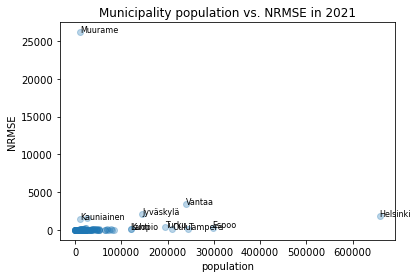

In [277]:
# Plot population vs. NRMSE of the municipalities in a scatter plot
populations, nrmses, labels = [], [], []
for u in G_original.nodes():
    populations.append(population[municipality_dict[u]][year])
    nrmses.append(nrmses_municipalities[u])
    if population[municipality_dict[u]][year] > 120000 or municipality_dict[u] == 'Muurame' or municipality_dict[u] == 'Kauniainen':
        labels.append(municipality_dict[u])
    else:
        labels.append('')
    
plt.scatter(populations, nrmses, alpha=0.3)
for i, label in enumerate(labels):
    plt.annotate(label, (populations[i], nrmses[i]), size=8)
plt.xlabel("population")
plt.ylabel("NRMSE")
plt.title(f"Municipality population vs. NRMSE in {year}")
plt.show()

Muurame has some problems as it is located almost completely inside Jyväskylä and the distance between their centers is only around $1.4$ kilometres. Kauniainen has similar problems, but not as much, as it is not located directly at the center of Espoo (distance between their centers is around $4.7$ kilometres).

### Accuracy on regions

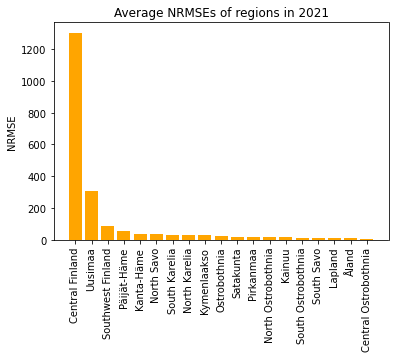

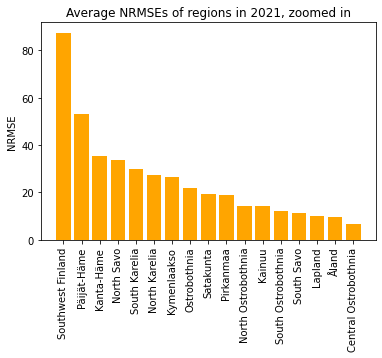

In [282]:
# Is the model more accurate for certain regions (maakunnat) than others?
# Let's calculate the average of the NRMSEs of the municipalities that belong to a certain region

# First, create a dictionary of which municipalities belong to which regions
kunta_to_maakunta = pd.read_csv('./kunta_to_maakunta.csv', dtype={'kunta_code':str})
municipality_region_list = kunta_to_maakunta[['kunta_code', 'maakunta_name']].values.tolist()
region_dict = {}
for municipality, region in municipality_region_list:
    if region not in region_dict:
        region_dict[region] = [municipality]
    else:
        region_dict[region].append(municipality)

# Calculate average NRMSEs of the regions
region_nrmses = {}
for region in region_dict:
    nrmses = [nrmses_municipalities[municipality] for municipality in nrmses_municipalities if municipality in region_dict[region]]
    average_nrmse = sum(nrmses)/len(nrmses)
    region_nrmses[region] = average_nrmse
    
# Plot the results in a bar plot
region_nrmses = dict(sorted(region_nrmses.items(), key=lambda item: item[1], reverse=True))
regions = [region for region in region_nrmses]
average_nrmses = [region_nrmses[region] for region in region_nrmses]
plt.bar(regions, average_nrmses, color='orange')
plt.xticks(rotation=90)
plt.ylabel("NRMSE")
plt.title(f"Average NRMSEs of regions in {year}")
plt.show()

# Plot the results without Central Finland and Uusimaa
regions_smaller = regions[2:]
average_nrmses_smaller = average_nrmses[2:]
plt.bar(regions_smaller, average_nrmses_smaller, color='orange')
plt.xticks(rotation=90)
plt.ylabel("NRMSE")
plt.title(f"Average NRMSEs of regions in {year}, zoomed in")
plt.show()